In [1]:
from IPython.core.display import HTML
# Apply styles globally within the notebook
HTML('''
<style>
  h2 {
    font-size: var(--jp-content-font-size4);
    background-color: #FF0000 ;
    color: yellow;
    display: flex;
    align-items: center;
    justify-content: center;
    padding: 10px 41px;
    top: 10px;
    position: relative;
    border-radius: 10px 50px 10px 50px;
}

img {       /* flex-grow: 1; */
            /* flex-shrink: 1; */
            border-radius: 150px 70px 150px 70px;
            border: 10px solid #eee;
            display: flex;
            align-items: center;
            justify-content: center;
            transition: box-shadow 0.3s ease; /* Add a transition for a smooth effect */
        }

       img:active {
          box-shadow: 0 10px 20px rgba(255, 255, 0, 0.5), 0 6px 6px rgba(215, 215, 0, 0.5);
        }
</style>
''')

## Fashion MNIST using Custom Training Loop


## Imports

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker

2025-01-06 16:05:28.722036: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 16:05:28.760217: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-06 16:05:29.011692: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-06 16:05:29.013213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-06 16:05:29.989641: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
train_data, info = tfds.load("mnist", split="train", with_info=True)
test_data = tfds.load("mnist", split="test")

2025-01-06 16:05:48.162116: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 100%|█████████████████████████| 5/5 [00:28<00:00,  5.64s/ file]

Dataset mnist downloaded and prepared to /home/abdalrahman/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.



2025-01-06 16:06:47.988476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-06 16:06:47.989852: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]


<div style="border: 2px solid yellow; padding: 10px; background-color: #F5F5F5; color: black; border-radius: 30px 45px 30px 45px;">

<p>&bull;  you normalize the images by dividing them by 255.0 so as to make the pixels fall in the range (0, 1).  </p>

<p>&bull; You also reshape the data so as to flatten the 28 x 28 pixel array into a flattened 784 pixel array. .    </p>

</div>

In [6]:
def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1])
    image = tf.cast(image, 'float32')
    image = image / 255.0
    return image, data["label"]

In [7]:
train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

<div style="border: 2px solid yellow; padding: 10px; background-color: #F5F5F5; color: black; border-radius: 30px 45px 30px 45px;">

<p>&bull;  Now you shuffle and batch your training and test datasets before feeding them to the model. </p>



</div>

In [8]:
batch_size = 64
train = train_data.shuffle(buffer_size=1024).batch(batch_size)

test =  test_data.batch(batch_size=batch_size)

In [9]:
def base_model():
  inputs = tf.keras.Input(shape=(784,), name='digits')
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_1')(inputs)
  x = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(x)
  outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

## Define Optimizer and Loss Function



<div style="border: 2px solid yellow; padding: 10px; background-color: #F5F5F5; color: black; border-radius: 30px 45px 30px 45px;">

<p>&bull;  Define Optimizer and Loss Function
You have chosen adam optimizer and sparse categorical crossentropy loss for this example. </p>



</div>

In [10]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

## Define Metrics
<div style="border: 2px solid yellow; padding: 10px; background-color: #F5F5F5; color: black; border-radius: 30px 45px 30px 45px;">

<p>&bull;  You will also define metrics so that your training loop can update and display them. Here you are using `SparseCategoricalAccuracy`defined in `tf.keras.metrics` since the problem at hand is a multi class classification problem. </p>



</div>


In [11]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

## Building Training Loop
In this section you build your training loop consisting of training and validation sequences.

<div style="border: 2px solid yellow; padding: 10px; background-color: #F5F5F5; color: black; border-radius: 30px 45px 30px 45px;">

<p>&bull;  YThe core of training is using the model to calculate the logits on specific set of inputs and compute loss (in this case **sparse categorical crossentropy**) by comparing the predicted outputs to the true outputs. You then update the trainable weights using the optimizer algorithm chosen. Optimizer algorithm requires your computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

You use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.</p>



</div>


In [12]:
def apply_gradient(optimizer, model, x, y):
  with tf.GradientTape() as tape:
    logits = model(x)
    loss_value = loss_object(y_true=y, y_pred=logits)
  
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, model.trainable_weights))
  
  return logits, loss_value

In [13]:
def train_data_for_one_epoch():
  losses = []
  pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
  for step, (x_batch_train, y_batch_train) in enumerate(train):
      logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
      
      losses.append(loss_value)
      
      train_acc_metric(y_batch_train, logits)
      pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
      pbar.update()
  return losses

In [14]:
def perform_validation():
  losses = []
  for x_val, y_val in test:
      val_logits = model(x_val)
      val_loss = loss_object(y_true=y_val, y_pred=val_logits)
      losses.append(val_loss)
      val_acc_metric(y_val, val_logits)
  return losses

<div style="border: 2px solid yellow; padding: 10px; background-color: #F5F5F5; color: black; border-radius: 30px 45px 30px 45px;">

<p>&bull; Next you define the training loop that runs through the training samples repeatedly over a fixed number of epochs.</p> 

<p>Here you combine the functions you built earlier to establish the following flow:</p>

<p>1. Perform training over all batches of training data.</p>
<p>2. Get values of metrics.</p>
<p>3. Perform validation to calculate loss and update validation metrics on test data.</p>
<p>4. Reset the metrics at the end of epoch.</p>
<p>5. Display statistics at the end of each epoch.</p>

<p>**Note** : You also calculate the training and validation losses for the whole epoch at the end of the epoch. .</p>



</div>


In [15]:

model = base_model()

# Iterate over epochs.
epochs = 10
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))
  
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()

  losses_val = perform_validation()
  val_acc = val_acc_metric.result()

  losses_train_mean = np.mean(losses_train)
  losses_val_mean = np.mean(losses_val)
  epochs_val_losses.append(losses_val_mean)
  epochs_train_losses.append(losses_train_mean)

  print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))
  
  train_acc_metric.reset_states()
  val_acc_metric.reset_states()




Start of epoch 0


Training loss for step 937: 0.3017: 100%|█████████████████████████████| 938/938 



 Epoch 0: Train loss: 0.3298  Validation Loss: 0.1672, Train Accuracy: 0.9041, Validation Accuracy 0.9504
Start of epoch 1


Training loss for step 937: 0.0188: 100%|█████████████████████████████| 938/938 



 Epoch 1: Train loss: 0.1426  Validation Loss: 0.1232, Train Accuracy: 0.9575, Validation Accuracy 0.9632
Start of epoch 2


Training loss for step 937: 0.0157: 100%|█████████████████████████████| 938/938 



 Epoch 2: Train loss: 0.1014  Validation Loss: 0.1095, Train Accuracy: 0.9694, Validation Accuracy 0.9664
Start of epoch 3


Training loss for step 937: 0.3047: 100%|█████████████████████████████| 938/938 



 Epoch 3: Train loss: 0.0795  Validation Loss: 0.1013, Train Accuracy: 0.9757, Validation Accuracy 0.9690
Start of epoch 4


Training loss for step 937: 0.0198: 100%|█████████████████████████████| 938/938 



 Epoch 4: Train loss: 0.0640  Validation Loss: 0.0917, Train Accuracy: 0.9807, Validation Accuracy 0.9713
Start of epoch 5


Training loss for step 937: 0.0029: 100%|█████████████████████████████| 938/938 



 Epoch 5: Train loss: 0.0532  Validation Loss: 0.0880, Train Accuracy: 0.9835, Validation Accuracy 0.9723
Start of epoch 6


Training loss for step 937: 0.0019: 100%|█████████████████████████████| 938/938 



 Epoch 6: Train loss: 0.0452  Validation Loss: 0.0877, Train Accuracy: 0.9859, Validation Accuracy 0.9728
Start of epoch 7


Training loss for step 937: 0.0175: 100%|█████████████████████████████| 938/938 



 Epoch 7: Train loss: 0.0380  Validation Loss: 0.0904, Train Accuracy: 0.9882, Validation Accuracy 0.9724
Start of epoch 8


Training loss for step 937: 0.0389: 100%|█████████████████████████████| 938/938 



 Epoch 8: Train loss: 0.0338  Validation Loss: 0.0884, Train Accuracy: 0.9894, Validation Accuracy 0.9738
Start of epoch 9


Training loss for step 937: 0.0055: 100%|█████████████████████████████| 938/938 



 Epoch 9: Train loss: 0.0300  Validation Loss: 0.0951, Train Accuracy: 0.9905, Validation Accuracy 0.9724


## Evaluate Model

### Plots for Evaluation
You plot the progress of loss as training proceeds over number of epochs.

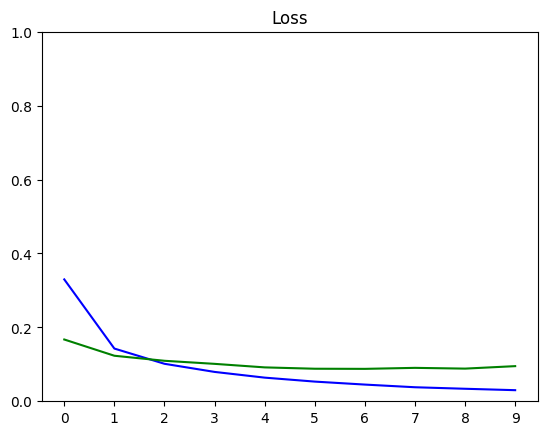

In [16]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.plot(train_metric,color='blue',label=metric_name)
  plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

This function displays a row of images with their predictions and true labels.

In [17]:
# utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

  display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

  plt.figure(figsize=(17,3))
  plt.title(title)
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], display_strings)
  plt.grid(None)
  image = np.reshape(image, [n, 28, 28])
  image = np.swapaxes(image, 0, 1)
  image = np.reshape(image, [28, 28*n])
  plt.imshow(image)

You make predictions on the test dataset and plot the images with their true and predicted values.

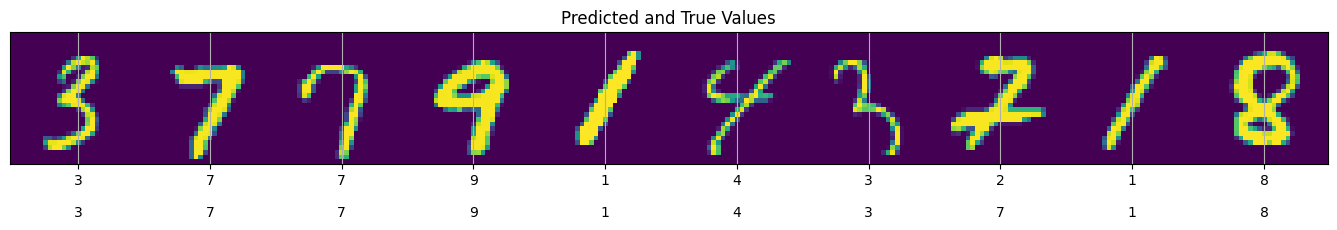

In [18]:
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
  y_pred = model(x)
  y_pred_batches = y_pred.numpy()
  y_true_batches = y.numpy()
  x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)

## Created By  : Eng/AbdalRhman Gameel Ahmed Hebishy 


<div style="border: 5px solid yellow; padding: 10px; background-color: #F5F5DC; color: blue; border-radius: 30px 45px 30px 45px;">


<img src="https://t4.ftcdn.net/jpg/04/00/26/99/360_F_400269908_gDF8JR2ctyHWiL1kww6WEWBerRzD5MBb.jpg" alt="My Image">

<p>&bull;  AbdalRhman Hebishy , DataScientist||Machine learning||Deeplearning Engineer 💻💻 .</p>

<p>&bull; <a href="https://www.kaggle.com/abdalrhamnhebishy" target="_blank">Kaggle profile 🔍</a>.</p>

<p>&bull; <a href="https://github.com/AbdalRahmna " target="_blank">Github profile 🐱</a>.</p>

<p>&bull; <a href="https://www.linkedin.com/in/abdalrahman-hebishy-06465b254/"_blank">linkedin profile 🧑‍💼</a>.</p>


</div>
